# Validation Code

## Link Formatting

In [1]:
# use this code to standardize the source paper URLs to start with 'https://' and DOIs to start with 'https://doi.org/'
import pandas as pd
import re

col = 'Source Paper'
df = pd.read_excel('dataset_checkpoints/01_merged_dataset.xlsx')

# Store original column for comparison
original_col = df[col].copy()

def standardize_url(url):
    if pd.isna(url) or not isinstance(url, str) or url.strip() == '':
        return url

    url = url.strip()

    # Convert http to https
    if url.startswith("http://"):
        url = "https://" + url[len("http://"):]

    # Replace dx.doi.org with doi.org
    url = re.sub(r"https://dx\.doi\.org/", "https://doi.org/", url)
    url = re.sub(r"http://dx\.doi\.org/", "https://doi.org/", url)

    # Ensure doi.org links start with https
    url = re.sub(r"http://doi\.org/", "https://doi.org/", url)

    return url

# Apply the standardization
df[col] = df[col].apply(standardize_url)

# Count how many entries changed
num_changed = (df[col] != original_col).sum()
print(f"✅ Number of entries changed: {num_changed}")

# Save the cleaned file
df.to_excel('dataset_checkpoints/test_01.xlsx', index=False)

✅ Number of entries changed: 250


Next, we manually removed some points, as per the Manual Correction step mentioned in the paper

## Duplicate Removal
Flag out works that appear in more than one initial dataset

In [2]:
import local_pkgs.proj_pkg.data_handler as dh
import pandas as pd

df = pd.read_excel('dataset_checkpoints/01_merged_dataset.xlsx')

diff_source_df = dh.check_doi_source(df)

In [3]:
diff_source_df['Source Paper'].nunique()
print(diff_source_df.shape)
print(diff_source_df['Source Paper'].unique())


doi_to_filter = 'https://doi.org/10.1021/acs.chemmater.7b01746'
diff_source_df[diff_source_df['Source Paper'] == doi_to_filter].shape

(126, 39)
['https://doi.org/10.1021/acs.chemmater.7b01746'
 'https://doi.org/10.1039/C6TA08467B']


(40, 39)

The extended MRL dataset for 'https://doi.org/10.1039/C6TA08467B' has already been flagged for removal due to extremely high zT values. Thus, notwithstanding that repetition, there is there is 1 DOI ('https://doi.org/10.1021/acs.chemmater.7b01746') that is repeated in extended MRL and ESTM datasets, comprising 40 entries.

Removed the ones from the extended MRL set

## Extra: Check Unique \# and No Missing \#
extra step to ensure the \# is unique and also check which \# are removed manually/ missing

In [4]:
import pandas as pd

df = pd.read_excel('dataset_checkpoints/02_data_manually_cleaned.xlsx')

# Total number of expected points
final_index = 10198
list_start = 0

# Actual indices from the DataFrame
actual_indices = set(df['#'])

# Expected full range of indices
expected_indices = set(range(list_start, list_start + final_index + 1))

# Missing indices
missing_indices = sorted(expected_indices - actual_indices)

print(f"Number of missing indices: {len(missing_indices)}")
print("Missing indices:", missing_indices)

duplicates = df[df.duplicated('#')]
print(f"Number of duplicate indices: {len(duplicates)}")

Number of missing indices: 1126
Missing indices: [1280, 1415, 1840, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1994, 1995, 1996, 1997, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2070, 2072, 2075, 2078, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2130, 2131, 2134, 2135, 2138, 2142, 2143, 2287, 2308, 2309, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2661, 2686, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2912, 2913, 2914, 2915, 2971, 2972, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3040, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 31

## Adding Column: Year of Publication of Source Paper
CrossRef API used. For APIs that failed the DOIs or other links, manually add those years.

In [5]:
import pandas as pd
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import multiprocessing
import time
import logging
import random
import re

failed_dois = []

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Step 3: Determine maximum threads based on system CPU count
def get_max_threads():
    cpu_count = multiprocessing.cpu_count()
    max_threads = max(1, cpu_count // 2)  # Reduce threads to avoid API rate limits
    return max_threads

# Step 4: Define the function to extract DOI suffix and get the publication year using CrossRef API with enhanced retries
def get_publication_year_crossref(doi_link):
    if pd.isna(doi_link):
        logging.error(f"Invalid DOI format: {doi_link}")
        failed_dois.append(doi_link)
        return None
    
    # Extract DOI suffix using regex to handle different formats
    match = re.search(r'(10\.\d{4,9}/[-._;()/:A-Z0-9]+)', doi_link, re.IGNORECASE)
    if not match:
        logging.error(f"Could not extract DOI from: {doi_link}")
        failed_dois.append(doi_link)
        return None

    doi_suffix = match.group(1)  # Get the DOI part of the link
    api_url = f"https://api.crossref.org/works/{doi_suffix}"
    
    retries = 10
    last_status_code = None
    for attempt in range(retries):
        try:
            response = requests.get(api_url)
            last_status_code = response.status_code
            if response.status_code == 200:
                data = response.json()
                # Log the entire response to understand its structure if extraction fails
                if 'message' in data:
                    message = data['message']
                    if 'published-print' in message and 'date-parts' in message['published-print']:
                        year = message['published-print']['date-parts'][0][0]
                        return str(year)
                    elif 'published-online' in message and 'date-parts' in message['published-online']:
                        year = message['published-online']['date-parts'][0][0]
                        return str(year)
                    else:
                        # Log detailed information about missing publication year
                        logging.error(f"Publication year not found in response for DOI: {doi_link}. Response: {data}")
                else:
                    logging.error(f"Unexpected response format for DOI: {doi_link}. Response: {data}")
                # Break early if we identify the response structure issue to avoid unnecessary retries
                break
            elif response.status_code == 404:
                logging.error(f"DOI not found in CrossRef: {doi_link}")
                failed_dois.append(doi_link)
                return None
            elif response.status_code == 429:
                retry_after = response.headers.get("Retry-After")
                if retry_after:
                    sleep_time = int(retry_after) + random.uniform(1, 5)
                    logging.warning(f"Rate limit hit, retrying after {sleep_time} seconds for DOI: {doi_link}")
                    time.sleep(sleep_time)
                else:
                    sleep_time = 180
                    logging.warning(f"Retry {attempt + 1}/{retries} for DOI: {doi_link} due to {response.status_code}, pausing for {sleep_time} seconds")
                    time.sleep(sleep_time)
            elif response.status_code in {500, 503}:
                logging.warning(f"Retry {attempt + 1}/{retries} for DOI: {doi_link} due to {response.status_code}")
                time.sleep(2 ** attempt)
            else:
                logging.error(f"Failed to get year for DOI: {doi_link} with status code: {response.status_code}")
                failed_dois.append(doi_link)
                return None
        except Exception as e:
            logging.error(f"Exception for DOI: {doi_link}, attempt {attempt + 1}/{retries}: {e}")
            time.sleep(2 ** attempt)
    
    logging.error(f"Exceeded maximum retries for DOI: {doi_link}, last status code: {last_status_code}")
    failed_dois.append(doi_link)
    return None

In [7]:
# Load the Excel file
file_path = 'dataset_checkpoints/02_data_manually_cleaned.xlsx'
df = pd.read_excel(file_path)

# Track failed DOIs for manual inspection
failed_dois = []

# Remove duplicates and create a lookup dictionary for DOIs in the full dataset
unique_dois = df['Source Paper'].dropna().unique()

# Use ThreadPoolExecutor with maximum workers based on system capacity
max_workers = get_max_threads()
print(f"Using {max_workers} threads based on system capacity.")

doi_to_year = {}
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    future_to_doi = {executor.submit(get_publication_year_crossref, doi): doi for doi in unique_dois}
    for future in as_completed(future_to_doi):
        doi = future_to_doi[future]
        try:
            year = future.result()
            doi_to_year[doi] = year
        except Exception as e:
            doi_to_year[doi] = None
            logging.error(f"Failed to get result for DOI: {doi} with error: {e}")

df['Year'] = pd.to_numeric(df['Source Paper'].map(doi_to_year), errors='coerce').astype('Int64')

print(f"Number of failed DOIs: {len(failed_dois)}")
print("Failed DOIs:", failed_dois)

Using 5 threads based on system capacity.


2025-06-23 23:54:20,885 - ERROR - Could not extract DOI from: https://www.jmst.org/EN/Y2009/V25/I04/0535
2025-06-23 23:54:27,719 - ERROR - Publication year not found in response for DOI: https://doi.org/10.1109/ICT.1996.553263. Response: {'status': 'ok', 'message-type': 'work', 'message-version': '1.0.0', 'message': {'indexed': {'date-parts': [[2025, 4, 30]], 'date-time': '2025-04-30T10:26:26Z', 'timestamp': 1746008786079, 'version': '3.28.0'}, 'reference-count': 18, 'publisher': 'IEEE', 'content-domain': {'domain': [], 'crossmark-restriction': False}, 'short-container-title': [], 'DOI': '10.1109/ict.1996.553263', 'type': 'proceedings-article', 'created': {'date-parts': [[2002, 12, 24]], 'date-time': '2002-12-24T01:52:43Z', 'timestamp': 1040694763000}, 'page': '91-95', 'source': 'Crossref', 'is-referenced-by-count': 69, 'title': ['High figure of merit in Ce-filled skutterudites'], 'prefix': '10.1109', 'author': [{'given': 'J.-P.', 'family': 'Fleurial', 'sequence': 'first', 'affiliation

Number of failed DOIs: 6
Failed DOIs: ['https://www.jmst.org/EN/Y2009/V25/I04/0535', 'https://doi.org/10.1109/ICT.1996.553263', 'https://www.jstor.org/stable/2889796', 'https://orbit.dtu.dk/en/publications/improvement-of-niobium-doped-srtio3-by-nanostructuring(2b6f4b33-1a6f-4472-ac18-6996f91cd743).html', 'https://doi.org/10.1007/978-3-540-88201-5_24', 'https://doi.org/10.1109/ICT.1999.843362']


- Manually add in Year for entries that throw an error
- Note: Some of the Year of Publication returned through this function may differ from what is in the final dataset. This is likely due to one of the following reasons: different API versions, or the year was compiled manually, which used the date of first publication rather than what the API extracted.

In [ ]:
# output_file_path = 'dataset_checkpoints/02_data_manually_cleaned.xlsx'  # Replace with your desired output file path

# df.to_excel(output_file_path, index=False)

# if failed_dois:
#     with open('failed_dois.txt', 'w') as file:
#         for doi in failed_dois:
#             file.write(f"{doi}\n")
#     print(f"Failed DOIs saved in 'failed_dois.txt' for manual inspection.")

## Systematic verification of kappa, PF and zT

In [8]:
import local_pkgs.proj_pkg.data_handler as dh
import pandas as pd
import os
import yaml

data = pd.read_excel('dataset_checkpoints/02_data_manually_cleaned.xlsx')

# check year has no blanks
print(data['Year'].isna().sum())

0


In [9]:
# check and remove any values that are zero in the columns specified in the YAML file
with open("thermoelectric_properties.yaml", "r", encoding="utf-8") as file:
    properties = yaml.safe_load(file)

exceed_threshold_df = data

for k, v in properties.items():
    col = v['column_name']
    print(f"Filtering data for column: {col}...")
    print(f"Initial data shape: {exceed_threshold_df.shape}")
 
    exceed_threshold_df = dh.filter_zero_entries(exceed_threshold_df, column_name=col, index_column='#')
    print(f"Filtered data shape: {exceed_threshold_df.shape}\n")

Filtering data for column: Total Thermal Conductivity (W/mK)...
Initial data shape: (9073, 40)
Filtered data shape: (9073, 40)

Filtering data for column: Electronic Thermal Conductivity (W/mK)...
Initial data shape: (9073, 40)
Filtered data shape: (9073, 40)

Filtering data for column: Lattice Thermal Conductivity (W/mK)...
Initial data shape: (9073, 40)
Filtered data shape: (9073, 40)

Filtering data for column: Electrical Conductivity (S/cm)...
Initial data shape: (9073, 40)
Filtered data shape: (9073, 40)

Filtering data for column: Seebeck Coefficient (µV/K)...
Initial data shape: (9073, 40)
Filtered data shape: (9073, 40)

Filtering data for column: Power Factor (µW/cmK²)...
Initial data shape: (9073, 40)
Filtered data shape: (9073, 40)

Filtering data for column: zT...
Initial data shape: (9073, 40)
Filtered data shape: (9073, 40)



### kappa verification

In [10]:
df =  dh.thermal_conductivity_verification(exceed_threshold_df, verbose=1)
col = "Thermal Conductivities Modification / Verification"

Total rows: 9073
Unmodified rows: 6856
Total Thermal Conductivity added: 0
Lattice Thermal Conductivity added: 740
Electronic Thermal Conductivity added: 1105
Number of Fully Filled Entries: 372


In [11]:
threshold = 0.1
within_threshold_df, exceed_threshold_df = dh.filter_by_threshold(df, threshold, col)

print(exceed_threshold_df.shape)

(0, 41)


Skip filtering as all are within the 10% threshold

### PF verification

In [12]:
df_copy = df.copy()
df = dh.power_factor_verification(df_copy, verbose=1)
col = 'Power Factor Modification / Verification'

Total rows: 9073
Unmodified rows: 71
Power Factor added: 374
Seebeck Coefficient added: 42. Remember to check the sign.
Electrical Conductivity added: 59
Number of Fully Filled Entries: 8527


In [13]:
threshold = 0.1
within_threshold_df, exceed_threshold_df = dh.filter_by_threshold(df, threshold, col, index_column="#")
print(exceed_threshold_df.shape)

Removed entries (values above or equal to 0.1):
         # Power Factor Modification / Verification
5083  6143                                12.016099
1437  1439                                 9.162988
5088  6148                                 7.194342
1414  1416                                 4.494201
5084  6144                                 4.151861
...    ...                                      ...
64      64                                 0.102042
19      19                                 0.101292
5098  6158                                 0.100609
60      60                                 0.100494
1072  1072                                 0.100345

[252 rows x 2 columns]
(252, 42)


In [14]:
df_copy = df.copy()
df = within_threshold_df

In [15]:
# filter out entries with Seebeck Coefficient Added During This Step. We will check the sign manually.
message = "Seebeck Coefficient added. Remember to check the sign."

seebeck_added_by_formula_df = df[df[col] == message]

seebeck_added_by_formula_df['Source Paper'].unique()

# df.to_excel("dataset_checkpoints/03_Seebeck_Check.xlsx", index=False)

array(['https://doi.org/10.1039/D1EE02986J',
       'https://doi.org/10.1016/j.materresbull.2019.110650'], dtype=object)

In our case, the Seebeck Coefficients should be negative instead of the default positive. We change them using the code below:

In [ ]:
# Seebeck coefficient for these should be negative instead of the default positive, change this in the main df
df_copy = df.copy()
df.loc[seebeck_added_by_formula_df.index, 'Seebeck Coefficient (µV/K)'] = -df.loc[seebeck_added_by_formula_df.index, 'Seebeck Coefficient (µV/K)']

In [17]:
# check that the only rows that are different are the ones that were changed
assert df.loc[seebeck_added_by_formula_df.index].equals(df_copy.loc[seebeck_added_by_formula_df.index]) == False

# Get all row indices that were not modified
unchanged_indices = df.index.difference(seebeck_added_by_formula_df.index)

# Check that the rows which were not modified are the same in both dataframes
assert df.loc[unchanged_indices].equals(df_copy.loc[unchanged_indices])

### zT verification

In [18]:
df_copy = df.copy()
df = dh.zt_verification(df_copy, verbose=1)
col = "zT Modification / Verification"


Total rows: 8821
Unmodified rows: 651
zT added: 84
Power Factor added: 1
Temperature added: 0
Total Thermal Conductivity added: 143
Number of Fully Filled Entries: 7942


In [19]:
threshold = 0.1
within_threshold_df, exceed_threshold_df = dh.filter_by_threshold(df, threshold, col, index_column="#")
print(exceed_threshold_df.shape)

Removed entries (values above or equal to 0.1):
         # zT Modification / Verification
3024  3249                       4.524755
3028  3253                       3.757343
119    119                       3.310479
128    128                       3.309834
110    110                        3.20601
...    ...                            ...
6287  7391                       0.100499
2823  2905                       0.100012
3020  3157                       0.100009
3008  3145                       0.100003
3016  3153                       0.100001

[363 rows x 2 columns]
(363, 43)


In [20]:
df_copy = df.copy()
df = within_threshold_df

### kappa Verification Again

In [21]:
col = "Thermal Conductivities Modification / Verification"

df_copy = df.drop(col, axis=1)
df =  dh.thermal_conductivity_verification(df_copy, verbose=1)

Total rows: 8458
Unmodified rows: 6422
Total Thermal Conductivity added: 0
Lattice Thermal Conductivity added: 18
Electronic Thermal Conductivity added: 42
Number of Fully Filled Entries: 1976


In [22]:
threshold = 0.1
within_threshold_df, exceed_threshold_df = dh.filter_by_threshold(df, threshold, col, index_column="#")
print(exceed_threshold_df.shape)

(0, 43)


### PF Verification Again
Rationale is that PF values and K values are added thus we should run those code again

In [23]:
col = 'Power Factor Modification / Verification'

# drop the col
df_copy = df.drop(col, axis=1)
df = dh.power_factor_verification(df_copy, verbose=1)

Total rows: 8458
Unmodified rows: 71
Power Factor added: 0
Seebeck Coefficient added: 0. Remember to check the sign.
Electrical Conductivity added: 0
Number of Fully Filled Entries: 8387


In [24]:
threshold = 0.1
within_threshold_df, exceed_threshold_df = dh.filter_by_threshold(df, threshold, col, index_column="#")
print(exceed_threshold_df.shape)

(0, 43)


### zT Verification Again

In [25]:
col = "zT Modification / Verification"
df_copy = df.drop(col, axis=1)
df = dh.zt_verification(df_copy, verbose=1)

Total rows: 8458
Unmodified rows: 651
zT added: 0
Power Factor added: 0
Temperature added: 0
Total Thermal Conductivity added: 0
Number of Fully Filled Entries: 7807


In [26]:
threshold = 0.1
within_threshold_df, exceed_threshold_df = dh.filter_by_threshold(df, threshold, col, index_column="#")
print(exceed_threshold_df.shape)

(0, 43)


We should repeat kappa, PF and zT verification if new points are still added. Here, as no new points are added, we stop the process. Refer to the paper for more details.

## Save as output

In [ ]:
df.to_excel("dataset_checkpoints/03_systematically_removed_data.xlsx", index=False)

## Extra: Check that the compositions contain only valid elements

i.e. T2O3 is wrong as T is not an element

In [28]:
import pandas as pd
import re

# List of chemical elements
chemical_elements = [
    "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne",
    "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
    "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y", "Zr",
    "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn",
    "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce", "Pr", "Nd",
    "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb",
    "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg",
    "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th",
    "Pa", "U", "Np", "Pu", "Am", "Cm", "Bk", "Cf", "Es", "Fm",
    "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds",
    "Rg", "Cn", "Nh", "Fl", "Mc", "Lv", "Ts", "Og"
]

# Compile a regex for valid substrings
valid_elements_pattern = "|".join(chemical_elements)  # Match chemical elements
valid_pattern = re.compile(rf"^({valid_elements_pattern}|wt|%|\d+|[()+\-(). ]+)+$")

# Function to validate compositions
def validate_composition_elements(composition):
    return bool(valid_pattern.match(composition))

In [30]:
data = pd.read_excel('dataset_checkpoints/03_systematically_removed_data.xlsx')

data["Is_Valid"] = data["Pretty Formula"].apply(validate_composition_elements)

data["Is_Valid"].all()

True

## Convert Formula to Pymatgen compatible objects and reduce formula

In [11]:
import local_pkgs.proj_pkg.data_handler as dh
import pandas as pd
from pymatgen.core.composition import Composition
import local_pkgs.proj_pkg.preprocessing as preprocess

data = pd.read_excel('dataset_checkpoints/03_systematically_removed_data.xlsx')

In [12]:
column_name = 'Type of Formula'

data_size = len(data)


mixed_size = (data[column_name] == 'Mixed Formula').sum()

print(f"Total data size: {data_size}")
print(f"Mixed formula size: {mixed_size}")
print(f"Percentage of mixed formula: {mixed_size / data_size * 100:.2f}%")

Total data size: 8458
Mixed formula size: 217
Percentage of mixed formula: 2.57%


In [13]:
# remove missing values from the 'Stoichiometric or Mass Ratio?' column
print(f"Initial data shape: {data.shape}")
data = data.dropna(subset=['Type of Formula'])
print(f"Data shape after removing missing values: {data.shape}")

pretty_formula_series = data['Pretty Formula']
formula_type_series = data['Type of Formula']

pymatgen_comp_series = dh.convert_to_composition(pretty_formula_series, formula_type_series)


data.insert(3, 'Pymatgen Composition', pymatgen_comp_series)

Initial data shape: (8458, 43)
Data shape after removing missing values: (8458, 43)


In [14]:
composition_col = "Pymatgen Composition"

# Apply reduction
preprocess.reduce_comps_in_df(data, composition_col, inplace=True)

# Create Composition objects
reduced_col = "reduced_compositions"

df = data.copy()
df["Composition (Original)"] = df[composition_col].apply(lambda x: Composition(str(x)) if pd.notnull(x) else None)
df["Composition (Reduced)"] = df[reduced_col].apply(lambda x: Composition(str(x)) if pd.notnull(x) else None)

# Compare
differences_mask = df["Composition (Original)"] != df["Composition (Reduced)"]

if differences_mask.any():
    differences_df = df.loc[differences_mask, ["Composition (Original)", "Composition (Reduced)"]]

In [ ]:
data.to_excel('dataset_checkpoints/04_composition_standardized_dataset.xlsx', index=False)

What remains is deleting columns on synthesis, processing and structural data as they were not fully collected and verified. Comments were also removed, leaving only the composition, transport properties, temperature and metadata.

Feel free to still use the intermediate datasets for your work, but they do not reflect the final work.

In [1]:
import pandas as pd

df = pd.read_excel('sysTEm_dataset.xlsx')

df['Initial Dataset'].value_counts()

ESTM            4998
This Work       2226
Extended MRL    1234
Name: Initial Dataset, dtype: int64

# Figures

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import local_pkgs.proj_pkg.graph_settings
import local_pkgs.proj_pkg.data_handler as dh
import pandas as pd
from pymatgen.core import Composition

## Dopant Line Plot

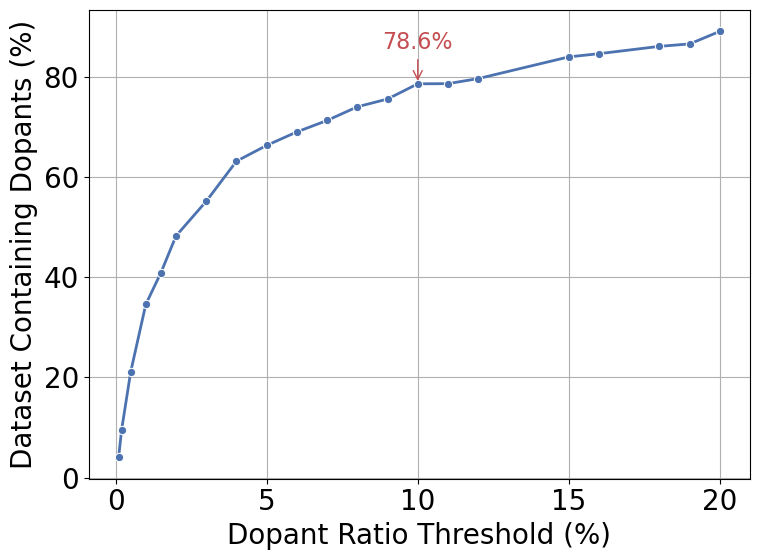

In [3]:
# Initialize an empty list to store the percentage of doped materials
doped_percentage_list = []
thresholds_percentages = [0.1, 0.2, 0.5, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18, 19, 20]  # List of thresholds to loop through

df = pd.read_excel('sysTEm_dataset.xlsx')
reduced_col = 'reduced_compositions'
reduced_col_series = df[reduced_col]

# Get the total number of entries
total_entries = len(df)

# Loop through different percentage thresholds and calculate the percentage of doped materials
for threshold_percent in thresholds_percentages:
    # Update the host_dopant_df based on the current threshold
    host_dopant_df = dh.classify_host_dopant_bulk(reduced_col_series, f"{threshold_percent}%")

    # Calculate the percentage of materials considered doped for the current threshold
    doped_entries = host_dopant_df.iloc[:, 1].notna().sum()  # Second column of host_dopant_df
    doped_percentage = (doped_entries / total_entries) * 100
    doped_percentage_list.append(doped_percentage)

# Create a DataFrame to store thresholds and doped percentages
doping_df = pd.DataFrame({
    'Threshold (%)': thresholds_percentages,
    'Doped Percentage (%)': doped_percentage_list
})

# Plot the data
plt.figure(figsize=(8, 6))
# sns.set(style="whitegrid", font='monospace')
palette = sns.color_palette("deep")
sns.lineplot(x='Threshold (%)', y='Doped Percentage (%)', data=doping_df, marker='o',color=palette[0], lw=2)
plt.grid(True)

# Add title and labels with the total number of entries mentioned in the title
# plt.title(f'Doped Materials Percentage by Threshold\nTotal Entries: {total_entries}')
plt.xlabel('Dopant Ratio Threshold (%)')
plt.ylabel('Dataset Containing Dopants (%)')

threshold_10 = doping_df[doping_df['Threshold (%)'] == 10]
if not threshold_10.empty:
    x_val = threshold_10['Threshold (%)'].values[0]
    y_val = threshold_10['Doped Percentage (%)'].values[0]

    # Add annotation at 10%
    plt.annotate(
        f'{y_val:.1f}%',  # Label text
        (x_val, y_val),   # Coordinates
        textcoords="offset points",  # Offset the text
        xytext=(0, 25),   # Text offset
        ha='center',      # Horizontal alignment
        fontsize=16,
        color = palette[3],
        arrowprops=dict(arrowstyle='->', lw=1, color=palette[3])  
    )
plt.tight_layout()

plt.savefig('figures/doped_a.pdf', dpi=300)

## Doped Vs Undoped zT
Take dopant ratio at 10%

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import local_pkgs.proj_pkg.graph_settings

In [5]:
df = pd.read_excel('sysTEm_dataset.xlsx')

reduced_col = "reduced_compositions"

# set doped vs undoped
dopant_ratio = '10.0%'
reduced_col_series = df[reduced_col]
host_dopant_df = dh.classify_host_dopant_bulk(reduced_col_series, dopant_ratio)    

# insert the host dopant columns after reduced compositions
insertion_idx = df.columns.get_loc(reduced_col) + 1

# Insert host_dopant_df right after reduced_col
df_combined = pd.concat(
    [df.iloc[:, :insertion_idx], host_dopant_df, df.iloc[:, insertion_idx:]],
    axis=1
)

# drop missing zT values
df_combined = df_combined.dropna(subset=['zT'])

df_doped = df_combined[df_combined[f'Dopant({dopant_ratio})'].notna()]
df_undoped = df_combined[df_combined[f'Dopant({dopant_ratio})'].isna()]

/var/folders/fv/kxzgtk4j1f56rn77jm5lg3w40000gn/T/ipykernel_56042/2826114216.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_doped['Type'] = 'Doped'
/var/folders/fv/kxzgtk4j1f56rn77jm5lg3w40000gn/T/ipykernel_56042/2826114216.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_undoped['Type'] = 'Undoped'
/var/folders/fv/kxzgtk4j1f56rn77jm5lg3w40000gn/T/ipykernel_56042/2826114216.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the

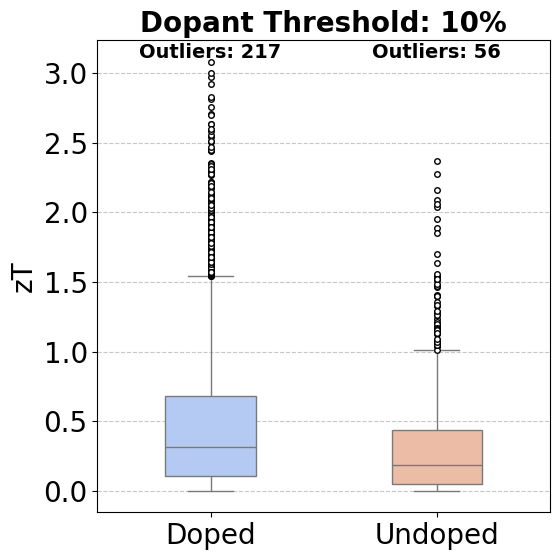

In [6]:
# Add 'Type' column for identification
prop_col = 'zT'
df_doped['Type'] = 'Doped'
df_undoped['Type'] = 'Undoped'

# Combine into a single DataFrame
df_combined = pd.concat([df_doped, df_undoped])

# Define IQR function to count outliers
def count_outliers(group):
    q1 = group[prop_col].quantile(0.25)
    q3 = group[prop_col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((group[prop_col] < lower) | (group[prop_col] > upper)).sum()

# Count outliers in each group
outlier_counts = df_combined.groupby('Type').apply(count_outliers)

# Plot settings
flierprops = {
    'marker': 'o',
    'markerfacecolor': 'white',
    'markeredgecolor': 'black',
    'markersize': 4,
    'linestyle': 'none'
}

palette = sns.color_palette("coolwarm", 2)

# Create box plot
plt.figure(figsize=(6, 6))
ax = sns.boxplot(
    x='Type',
    y=prop_col,
    data=df_combined,
    palette=[palette[0], palette[1]],
    width=0.4,
    flierprops=flierprops
)

# Annotate outlier counts
for i, (label, count) in enumerate(outlier_counts.items()):
    ax.text(i, df_combined[prop_col].max(), f'Outliers: {count}', 
            ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('')
plt.ylabel(f'{prop_col}', fontsize=20)
plt.title('Dopant Threshold: 10%', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('figures/doped_b.pdf', dpi=300)

## Elemental Heatmap
code taken from https://github.com/Andrew-S-Rosen/periodic_trends



In [ ]:
# code taken from https://github.com/Andrew-S-Rosen/periodic_trends

from bokeh.models import (
    ColumnDataSource,
    LinearColorMapper,
    LogColorMapper,
    ColorBar,
    BasicTicker,
)
from bokeh.plotting import figure, output_file
from bokeh.io import show as show_
from bokeh.sampledata.periodic_table import elements
from bokeh.transform import dodge
from csv import reader
from matplotlib.colors import Normalize, LogNorm, to_hex
from matplotlib.cm import (
    plasma,
    inferno,
    magma,
    viridis,
    cividis,
    turbo,
    ScalarMappable,
)
from pandas import options
from typing import List
import warnings
import seaborn as sns
import matplotlib.colors as mcolors

def plotter(
    filename: str,
    show: bool = True,
    output_filename: str = None,
    width: int = 1050,
    cmap: str = "plasma",
    alpha: float = 0.65,
    extended: bool = True,
    periods_remove: List[int] = None,
    groups_remove: List[int] = None,
    log_scale: bool = False,
    cbar_height: float = None,
    cbar_standoff: int = 12,
    cbar_fontsize: int = 14,
    blank_color: str = "#c4c4c4",
    under_value: float = None,
    under_color: str = "#140F0E",
    over_value: float = None,
    over_color: str = "#140F0E",
    special_elements: List[str] = None,
    special_color: str = "#6F3023",
) -> figure:

    """
    Plot a heatmap over the periodic table of elements.

    Parameters
    ----------
    filename : str
        Path to the .csv file containing the data to be plotted.
    show : str
        If True, the plot will be shown.
    output_filename : str
        If not None, the plot will be saved to the specified (.html) file.
    width : float
        Width of the plot.
    cmap : str
        plasma, inferno, viridis, magma, cividis, turbo
    alpha : float
        Alpha value (transparency).
    extended : bool
        If True, the lanthanoids and actinoids will be shown.
    periods_remove : List[int]
        Period numbers to be removed from the plot.
    groups_remove : List[int]
        Group numbers to be removed from the plot.
    log_scale : bool
        If True, the colorbar will be logarithmic.
    cbar_height : int
        Height of the colorbar.
    cbar_standoff : int
        Distance between the colorbar and the plot.
    cbar_fontsize : int
        Fontsize of the colorbar label.
    blank_color : str
        Hexadecimal color of the elements without data.
    under_value : float
        Values <= under_value will be colored with under_color.
    under_color : str
        Hexadecimal color to be used for the lower bound color.
    over_value : float
        Values >= over_value will be colored with over_color.
    under_color : str
        Hexadecial color to be used for the upper bound color.
    special_elements: List[str]
        List of elements to be colored with special_color.
    special_color: str
        Hexadecimal color to be used for the special elements.

    Returns
    -------
    figure
        Bokeh figure object.
    """

    options.mode.chained_assignment = None

    # Assign color palette based on input argument
    if cmap == "plasma":
        cmap = plasma
        bokeh_palette = "Plasma256"
    elif cmap == "inferno":
        cmap = inferno
        bokeh_palette = "Inferno256"
    elif cmap == "magma":
        cmap = magma
        bokeh_palette = "Magma256"
    elif cmap == "viridis":
        cmap = viridis
        bokeh_palette = "Viridis256"
    elif cmap == "cividis":
        cmap = cividis
        bokeh_palette = "Cividis256"
    elif cmap == "turbo":
        cmap = turbo
        bokeh_palette = "Turbo256"
    else:
        try:
            # Convert Seaborn or Matplotlib colormap to a Bokeh-compatible palette
            cmap = sns.color_palette(cmap, as_cmap=True)
            bokeh_palette = [mcolors.rgb2hex(cmap(i)) for i in range(256)]
        except ValueError:
            raise ValueError(f"Invalid color map: {cmap}")

    # Define number of and groups
    period_label = ["1", "2", "3", "4", "5", "6", "7"]
    group_range = [str(x) for x in range(1, 19)]

    # Remove any groups or periods
    if groups_remove:
        for gr in groups_remove:
            gr = gr.strip()
            group_range.remove(str(gr))
    if periods_remove:
        for pr in periods_remove:
            pr = pr.strip()
            period_label.remove(str(pr))

    # Read in data from CSV file
    data_elements = []
    data_list = []
    for row in reader(open(filename)):
        data_elements.append(row[0])
        data_list.append(row[1])
    data = [float(i) for i in data_list]

    if len(data) != len(data_elements):
        raise ValueError("Unequal number of atomic elements and data points")

    period_label.append("blank")
    period_label.append("La")
    period_label.append("Ac")

    if extended:
        count = 0
        for i in range(56, 70):
            elements.loc[i, 'period'] = "La"
            elements.loc[i, 'group'] = str(count + 4)
            count += 1

        count = 0
        for i in range(88, 102):
            elements.loc[i, 'period'] = "Ac"
            elements.loc[i, 'group'] = str(count + 4)
            count += 1

    # Define matplotlib and bokeh color map
    if log_scale:
        for datum in data:
            if datum < 0:
                raise ValueError(
                    f"Entry for element {datum} is negative but log-scale is selected"
                )
        color_mapper = LogColorMapper(
            palette=bokeh_palette, low=min(data), high=max(data)
        )
        norm = LogNorm(vmin=min(data), vmax=max(data))
    else:
        color_mapper = LinearColorMapper(
            palette=bokeh_palette, low=min(data), high=max(data)
        )
        norm = Normalize(vmin=min(data), vmax=max(data))

    # Generate color scale
    color_scale = ScalarMappable(norm=norm, cmap=cmap).to_rgba(data, alpha=None)

    # Set blank color
    color_list = [blank_color] * len(elements)

    # Compare elements in dataset with elements in periodic table
    for i, data_element in enumerate(data_elements):
        element_entry = elements.symbol[
            elements.symbol.str.lower() == data_element.lower()
        ]
        if element_entry.empty == False:
            element_index = element_entry.index[0]
        else:
            warnings.warn("Invalid chemical symbol: " + data_element)
        if color_list[element_index] != blank_color:
            warnings.warn("Multiple entries for element " + data_element)
        elif under_value is not None and data[i] <= under_value:
            color_list[element_index] = under_color
        elif over_value is not None and data[i] >= over_value:
            color_list[element_index] = over_color
        else:
            color_list[element_index] = to_hex(color_scale[i])

    if special_elements:
        for k, v in elements["symbol"].iteritems():
            if v in special_elements:
                color_list[k] = special_color

    # Define figure properties for visualizing data
    source = ColumnDataSource(
        data=dict(
            group=[str(x) for x in elements["group"]],
            period=[str(y) for y in elements["period"]],
            sym=elements["symbol"],
            atomic_number=elements["atomic number"],
            type_color=color_list,
        )
    )

    # Plot the periodic table
    p = figure(x_range=group_range, y_range=list(reversed(period_label)), tools="save")
    p.width = width
    p.outline_line_color = None
    p.background_fill_color = None
    p.border_fill_color = None
    p.toolbar_location = "above"
    p.rect("group", "period", 0.9, 0.9, source=source, alpha=alpha, color="type_color")
    p.axis.visible = False
    text_props = {
        "source": source,
        "angle": 0,
        "color": "black",
        "text_align": "left",
        "text_baseline": "middle",
    }
    x = dodge("group", -0.4, range=p.x_range)
    y = dodge("period", 0.3, range=p.y_range)
    p.text(
        x=x,
        y="period",
        text="sym",
        text_font_style="bold",
        text_font_size="16pt",
        **text_props,
    )
    p.text(x=x, y=y, text="atomic_number", text_font_size="11pt", **text_props)

    color_bar = ColorBar(
        color_mapper=color_mapper,
        ticker=BasicTicker(desired_num_ticks=10),
        border_line_color=None,
        label_standoff=cbar_standoff,
        location=(0, 0),
        orientation="vertical",
        scale_alpha=alpha,
        major_label_text_font_size=f"{cbar_fontsize}pt",
    )

    if cbar_height is not None:
        color_bar.height = cbar_height

    p.add_layout(color_bar, "right")
    p.grid.grid_line_color = None

    if output_filename:
        output_file(output_filename)

    if show:
        show_(p)

    return p

In [8]:
import pandas as pd
from pymatgen.core import Composition

# Element list
elem_ls = [
    'H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne',
    'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca',
    'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
    'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr',
    'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn',
    'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd',
    'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb',
    'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',
    'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th',
    'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm',
    'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds',
    'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og'
]

# Initialize element totals
element_totals = {ele: 0 for ele in elem_ls}

# Load the dataset
df = pd.read_excel('sysTEm_dataset.xlsx')
reduced_col = 'reduced_compositions'

# Count the elements
for comp_str in df[reduced_col]:
    try:
        comp = Composition(comp_str)  # Convert to Composition object
        for ele in comp.as_dict().keys():  # Ignore the amounts, just count presence
            element_totals[str(ele)] += 1
    except Exception as e:
        print(f"Error processing composition '{comp_str}': {e}")

# Prepare data for CSV
data = [(ele, total) for ele, total in element_totals.items() if total > 0]

# Output file
output_file = 'figures/element_presence.csv'
pd.DataFrame(data).to_csv(output_file, index=False, header=False)

print(f"CSV file created: {output_file}")

CSV file created: figures/element_presence.csv


In [9]:
plotter(filename=output_file, cmap='viridis', show=True)

figure(id='p1007', ...)

## Histogram Plots

In [11]:
import pandas as pd
from local_pkgs.proj_pkg import eda_plots as eda
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

with open("thermoelectric_properties.yaml", "r", encoding="utf-8") as file:
    properties = yaml.safe_load(file)

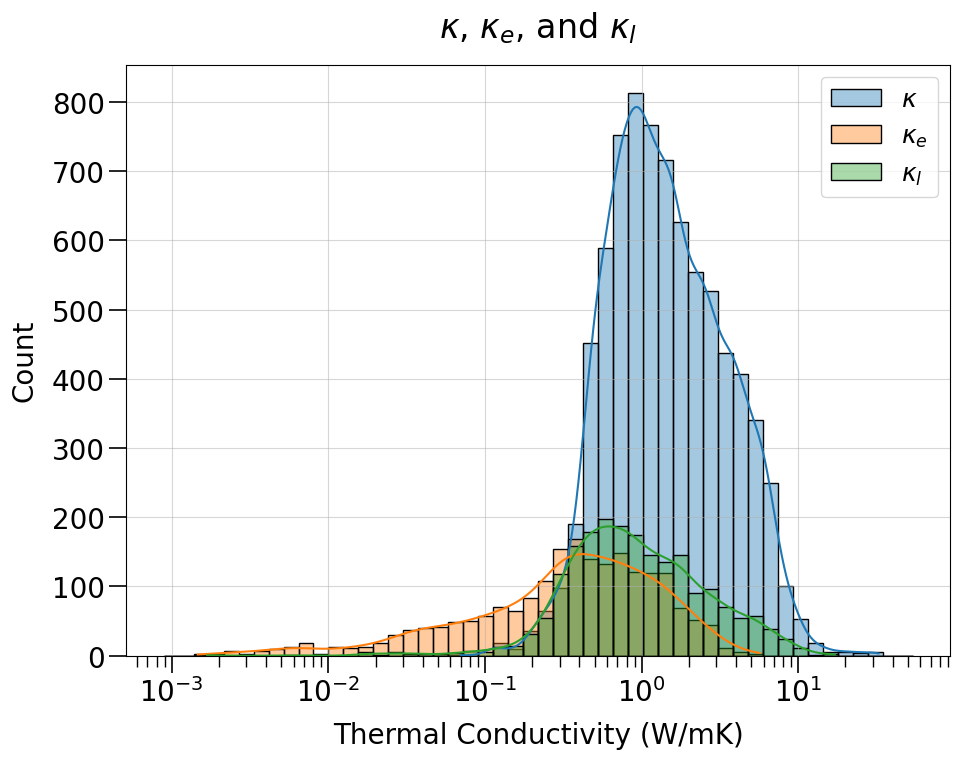

In [12]:
# Load dataset
df = pd.read_excel('sysTEm_dataset.xlsx')

# Define properties to plot
k_props = ['k', 'ke', 'kl']
k_labels = ['$\kappa$', r'$\kappa_e$', r'$\kappa_l$']
k_units = properties['k']['units']  # Assuming all three share the same units

# Determine common range for all three properties
min_val = float('inf')
max_val = float('-inf')
for prop in k_props:
    data = df[properties[prop]['column_name']].dropna()
    if properties[prop]['take_log']:
        data = np.log10(data)  # Apply log transformation if needed
    min_val = min(min_val, data.min())
    max_val = max(max_val, data.max())

# Add some padding to the range
padding = 0.05 * (max_val - min_val)
min_val -= padding
max_val += padding

# Define number of bins
bins = 50

# Define common bin edges for all histograms
bin_edges = np.linspace(min_val, max_val, bins + 1)

# Prepare figure
plt.figure(figsize=(10, 8))
plt.grid(alpha=0.5)

# Plot histograms for k, ke, and kl
for prop, label in zip(k_props, k_labels):
    takelog = properties[prop]['take_log']
    data = df[properties[prop]['column_name']].dropna()
    
    if takelog:
        plt.xscale('log')  # Apply log scale to the x-axis
        data = np.log10(data) if not plt.gca().get_xscale() == 'log' else data
    
    sns.histplot(data, bins=bin_edges, alpha=0.4, label=label, edgecolor='black', kde=True)

# Labels and title
plt.xlabel(f'Thermal Conductivity ({k_units})',labelpad=10)
plt.ylabel('Count',labelpad=10)
plt.tick_params(axis='both', which='major', length=12, width=1.2)
plt.tick_params(axis='both', which='minor', length=8, width=1)
plt.title('$\kappa$, $\kappa_e$, and $\kappa_l$', pad='20')
plt.legend(fontsize=18)
plt.tight_layout()

# Save plot
save_path = f'figures/properties_histogram_k_all_3.pdf'
plt.savefig(save_path, bbox_inches='tight')

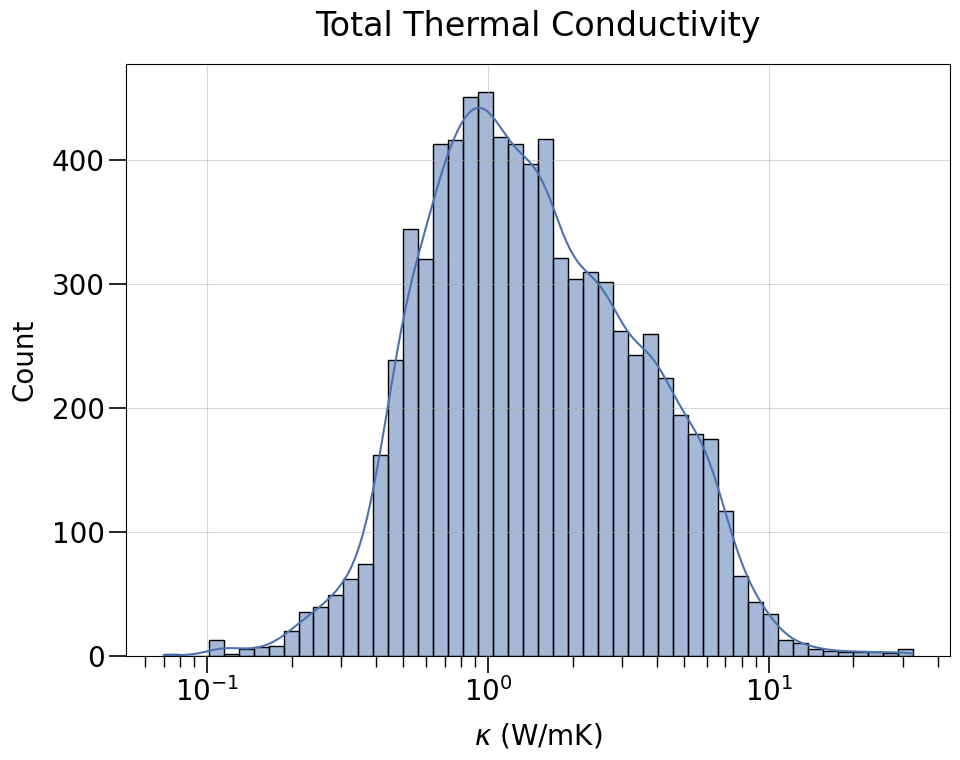

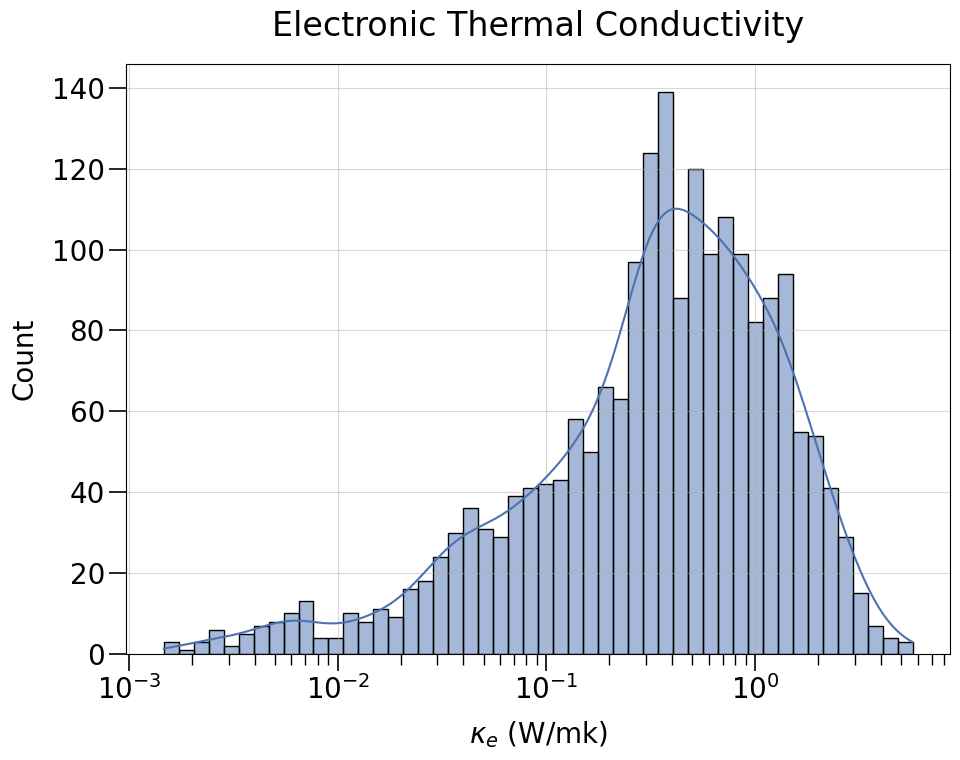

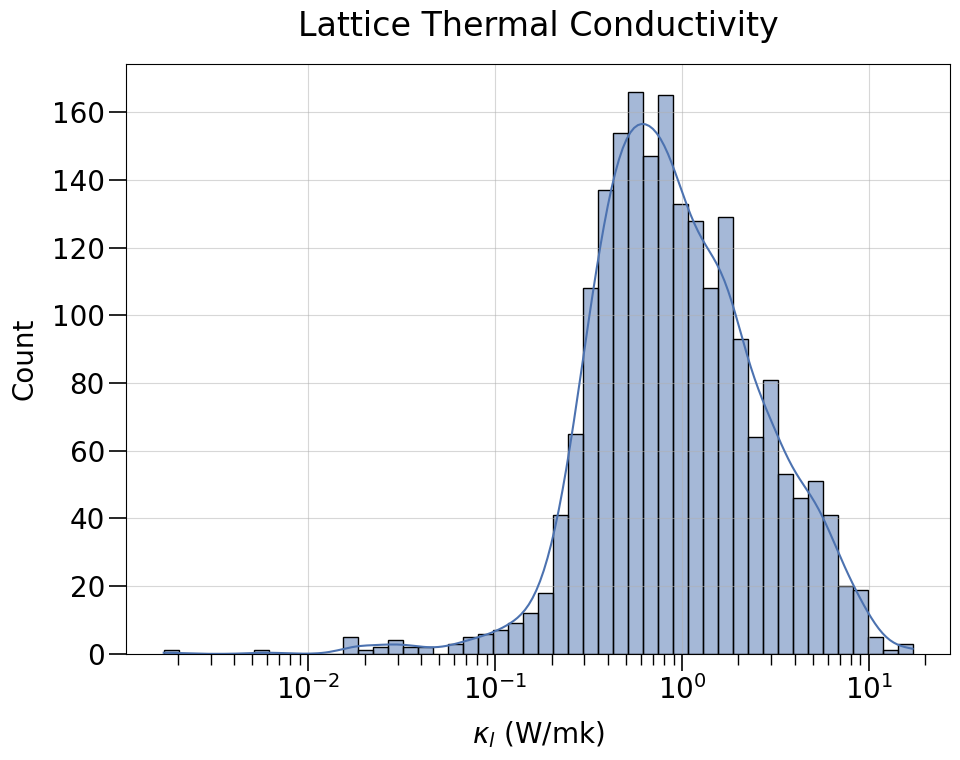

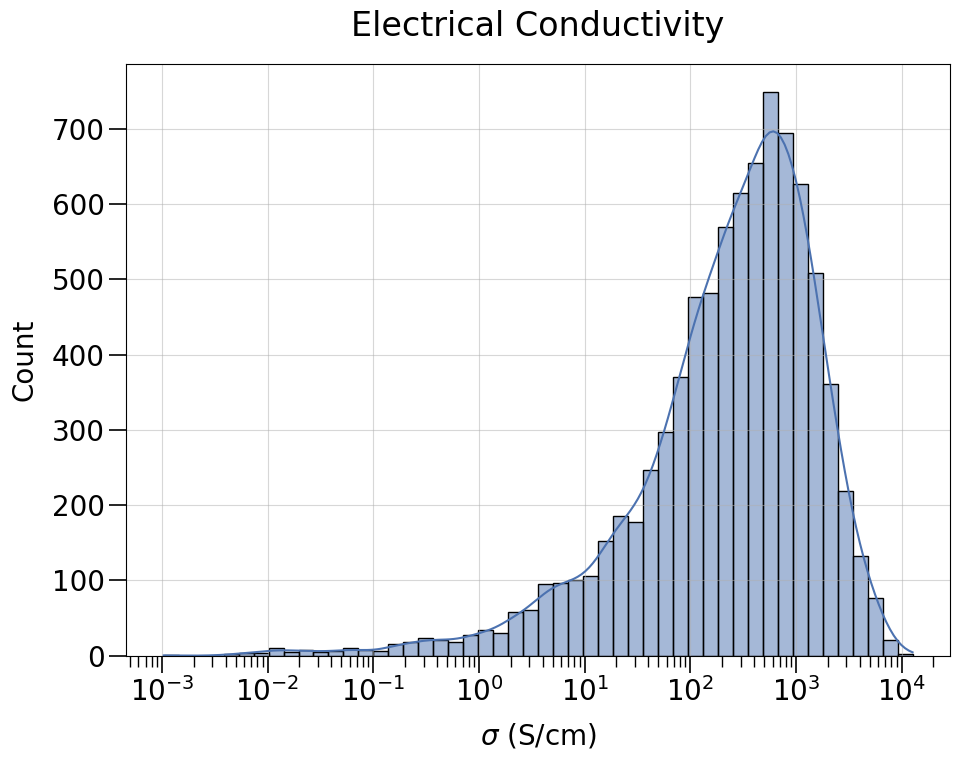

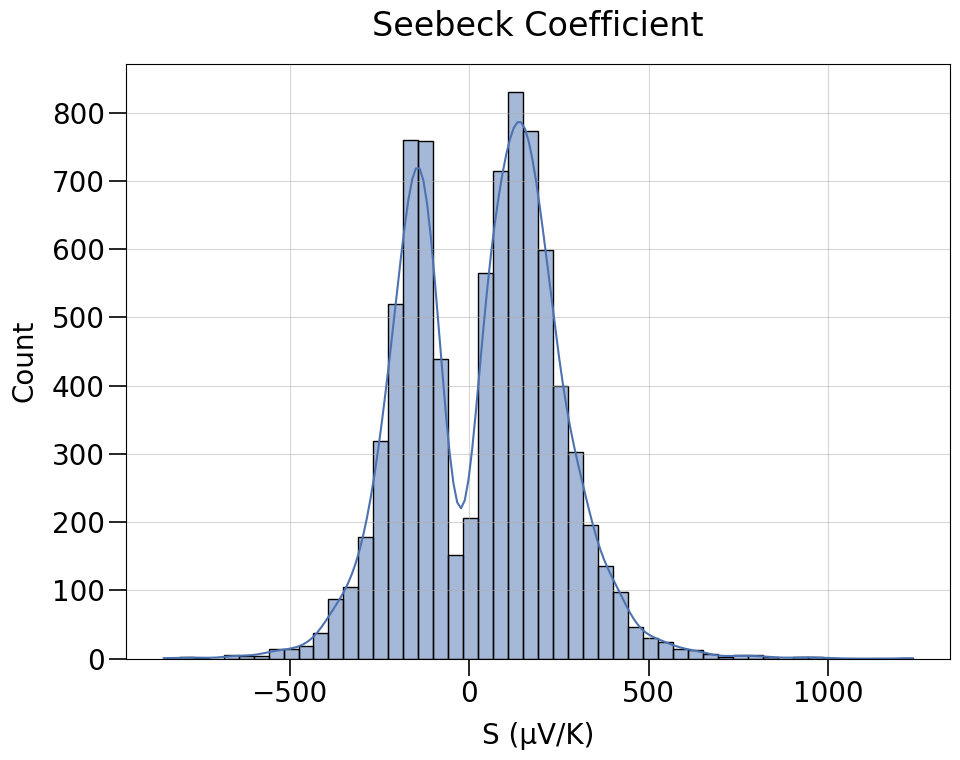

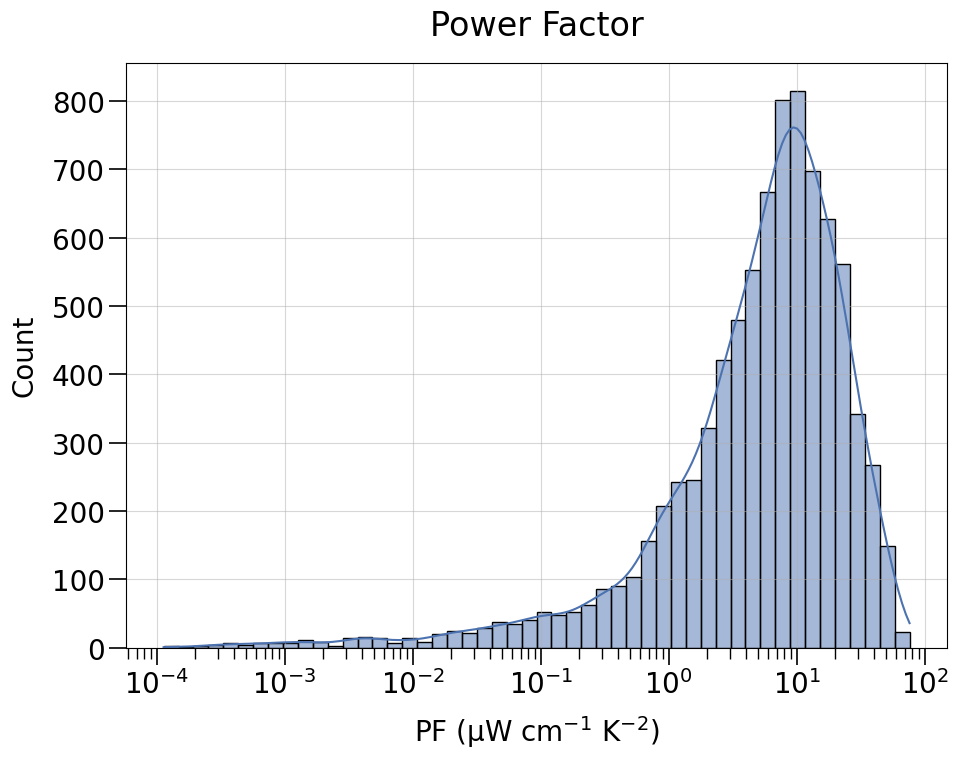

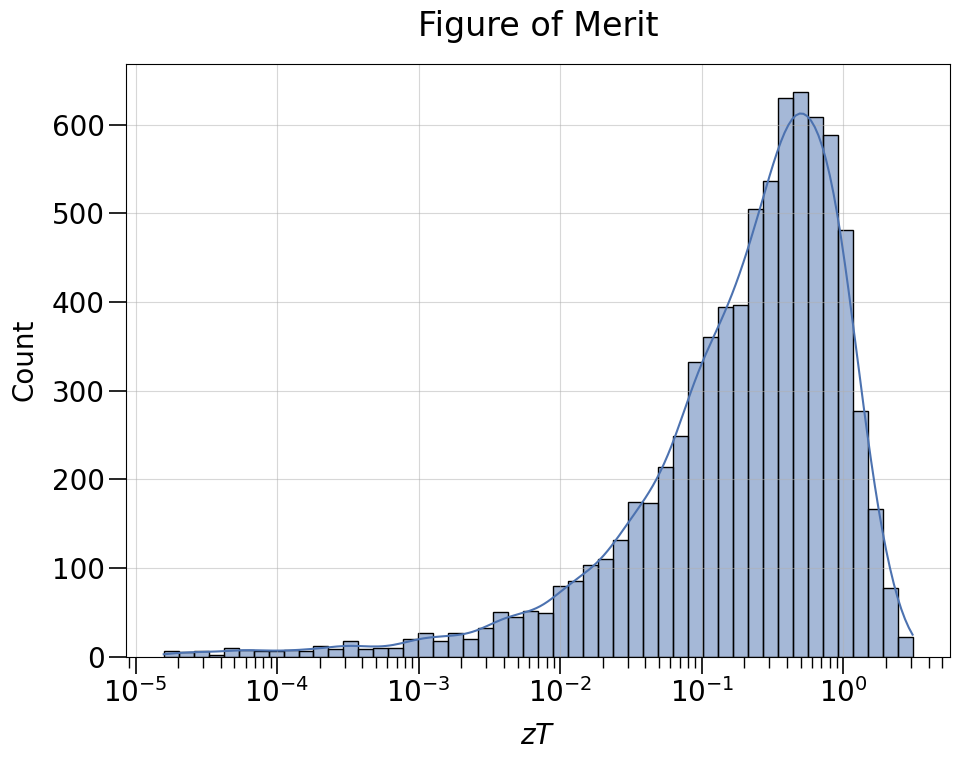

In [13]:
df = pd.read_excel('sysTEm_dataset.xlsx')

for property, v in properties.items():
    df_copy = df.copy()

    label = v['short_name']

    takelog = v['take_log']

    bins = 50

    title = f"{v['full_name']}"
    save_dir = f'figures/properties_histogram_{property}.pdf'


    eda.histogram_plot(df_copy[v['column_name']], title, label, v['units'], bins=bins, savedir=save_dir, takelog=takelog)


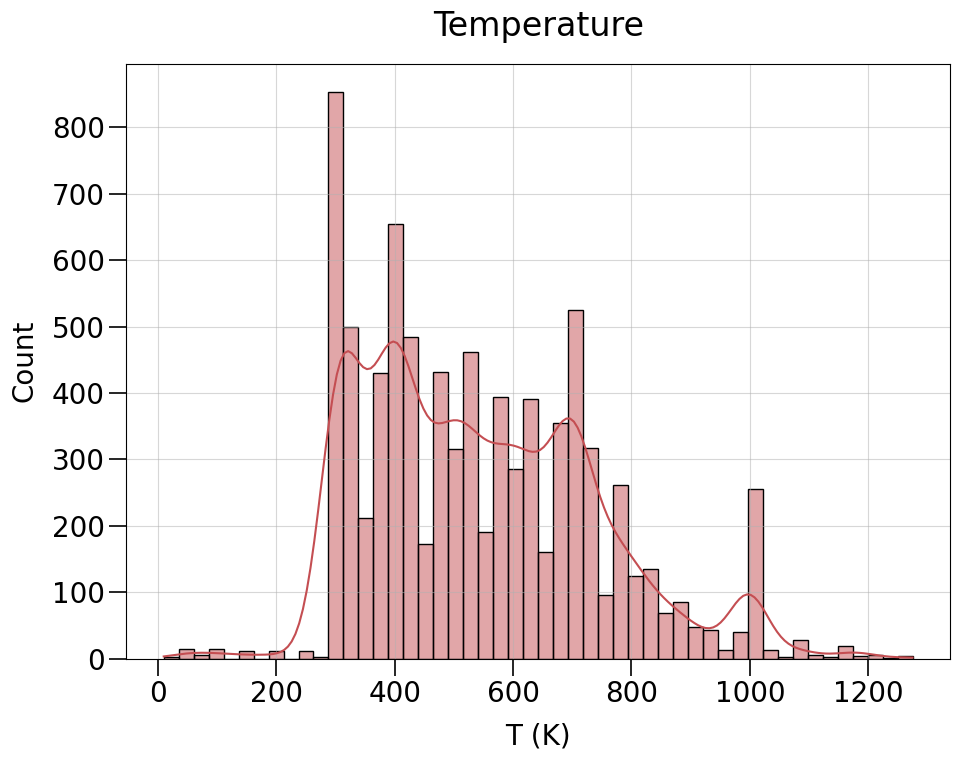

In [14]:
df = pd.read_excel('sysTEm_dataset.xlsx')

df_copy = df.copy()

takelog = False

bins = 50

title = "Temperature"
save_dir = f'figures/properties_histogram_temperature.pdf'


eda.histogram_plot(df_copy['Temperature (K)'], title, 'T', 'K', bins=bins, savedir=save_dir, takelog=takelog, color=sns.color_palette('deep')[3])


## Pearson Heatmap

In [15]:
import pandas as pd
from local_pkgs.proj_pkg import eda_plots as eda
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

with open("thermoelectric_properties.yaml", "r", encoding="utf-8") as file:
    properties = yaml.safe_load(file)

df = pd.read_excel("sysTEm_dataset.xlsx")

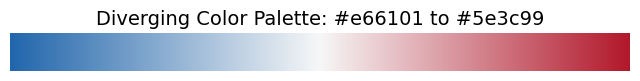

In [16]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 1))
fig.subplots_adjust(bottom=0.5)
colors = ['#2166ac','#f7f7f7','#b2182b']

# Generate a colormap
gradient = [colors]
cmap = LinearSegmentedColormap.from_list("CustomDiverging", colors)

# Show the gradient
gradient_image = ax.imshow([list(range(256))], aspect='auto', cmap=cmap)
ax.set_axis_off()

# Add a title
plt.title("Diverging Color Palette: #e66101 to #5e3c99", fontsize=14)
plt.show()

Figure saved to: figures/pearson_heatmap.pdf


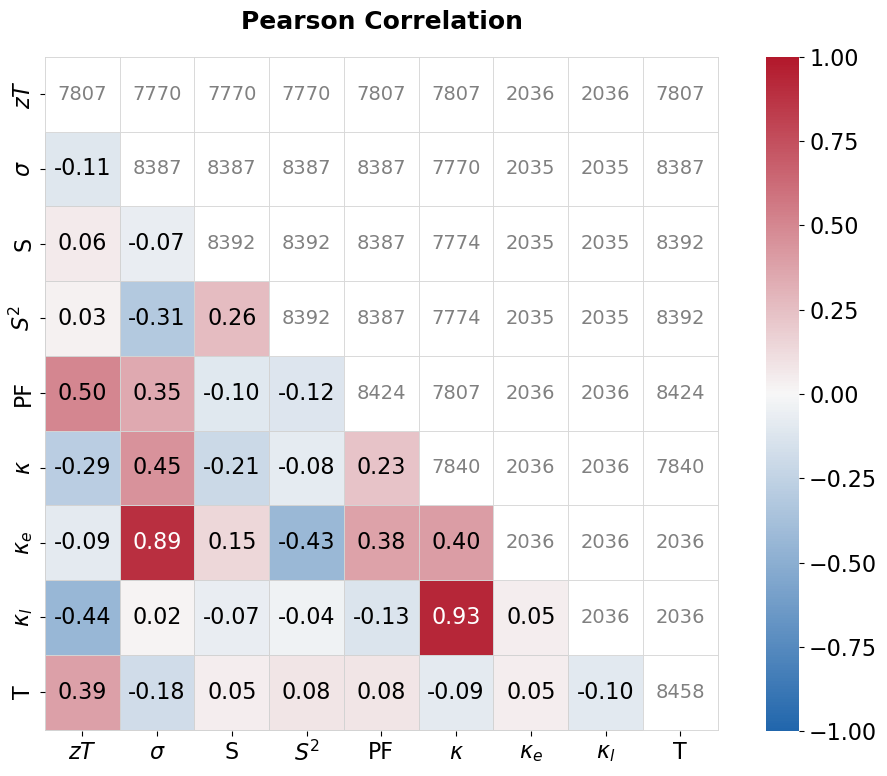

In [18]:
prop_short = []
df_copy = df.copy()

for prop, vals in properties.items():
    df_copy = df_copy.rename(columns={vals['column_name']: vals['short_name']})
    prop_short.append(vals['short_name'])

# Add temperature column
df_copy = df_copy.rename(columns={'Temperature (K)': 'T'})
prop_short.append('T')

# Add S^2 remove S
df_copy['$S^2$'] = df_copy['S']**2
prop_short.append('$S^2$')


# reorder the columns
prop_short = ['$zT$', '$\sigma$', 'S', '$S^2$', 'PF', '$\kappa$', '$\kappa_e$', '$\kappa_l$', 'T']

output = 'figures/pearson_heatmap.pdf'

title = 'Pearson Correlation'

# colormap=sns.diverging_palette(255, 0, s=75, l=40, sep=1, center='light', as_cmap=True)

eda.plot_pearson_correlation_full_heatmap(df_copy, prop_short, title, colormap=cmap, savefig=output)


In [10]:
import pandas as pd
import yaml

df_raw = pd.read_excel('dataset_checkpoints/01_merged_dataset.xlsx')
df_manual = pd.read_excel('dataset_checkpoints/02_data_manually_cleaned.xlsx')
df_cleaned = pd.read_excel('dataset_checkpoints/03_systematically_removed_data.xlsx')
df_final = pd.read_excel('sysTEm_dataset.xlsx')

df_raw.set_index('#', inplace=True)
df_manual.set_index('#', inplace=True)
df_cleaned.set_index('#', inplace=True)
df_final.set_index('#', inplace=True)


print("Raw DataFrame shape:", df_raw.shape)
print("Manual DataFrame shape:", df_manual.shape)
print("Cleaned DataFrame shape:", df_cleaned.shape)
print("Final DataFrame shape:", df_final.shape)


# Load properties YAML
with open("thermoelectric_properties.yaml", "r", encoding="utf-8") as file:
    properties = yaml.safe_load(file)

Raw DataFrame shape: (10194, 38)
Manual DataFrame shape: (9073, 39)
Cleaned DataFrame shape: (8458, 42)
Final DataFrame shape: (8458, 15)


In [ ]:
# Dictionary to store counts
systematically_added_counts = {}

# Iterate through each property
for prop_name, prop_info in properties.items():
    col = prop_info['column_name']
    
    count = 0
    for idx in df_final.index:
        val_final = df_final.at[idx, col] if col in df_final.columns else None
        val_raw = df_raw.at[idx, col] if col in df_raw.columns else None

        if pd.isna(val_raw) and not pd.isna(val_final):
            count += 1

    systematically_added_counts[prop_name] = count

# Show results
for k, v in systematically_added_counts.items():
    print(f"{k} ({properties[k]['column_name']}): {v} values systematically added")

k (Total Thermal Conductivity (W/mK)): 143 values systematically added
ke (Electronic Thermal Conductivity (W/mK)): 1017 values systematically added
kl (Lattice Thermal Conductivity (W/mK)): 716 values systematically added
sigma (Electrical Conductivity (S/cm)): 59 values systematically added
S (Seebeck Coefficient (µV/K)): 33 values systematically added
PF (Power Factor (µW/cmK²)): 312 values systematically added
zT (zT): 84 values systematically added
